In [26]:
%matplotlib inline
import pandas as pd
import os
from datetime import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from gpflow.utilities import print_summary
gpflow.config.set_default_summary_fmt("notebook")

# plotly viz - use matplotlib if you prefer
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# cleanair modules
from cleanair.scoot import ScootQuery

In [27]:
secretfile = "../../terraform/.secrets/db_secrets.json"

# choose a start and end date for this query
start_datetime_LD="2020-03-23 00:00:00"
end_datetime_LD="2020-03-24 00:00:00"

# choose a start and end date for querying "normal traffic" period
# start_datetime_normal="2020-02-10 00:00:00"
# end_datetime_normal="2020-02-25 00:00:00"

# choose a start and end date for querying "lockdown traffic" period
# start_datetime_LD="2020-03-16 00:00:00"
# end_datetime_LD="2020-03-26 00:00:00"

# columns to analyse
columns = ["n_vehicles_in_interval", "occupancy_percentage", "congestion_percentage", "saturation"]

SQ = ScootQuery(secretfile=secretfile)

2020-03-29 17:19:27     INFO: Database connection information loaded from <_io.TextIOWrapper name='../../terraform/.secrets/db_secrets.json' mode='r' encoding='UTF-8'>


# Detector readings
Get all scoot observations between `start_datetime` and `end_datetime`

In [ ]:
all_df = SQ.get_all_readings(start_datetime=start_datetime, end_datetime=end_datetime)

In [ ]:
## This is querying the full data which have been already saved - takes around 30 mins
#all_df_normal = SQ.get_all_readings(start_datetime=start_datetime, end_datetime=end_datetime)
#all_df_LD = SQ.get_all_readings(start_datetime=start_datetime_LD, end_datetime=end_datetime_LD)

In [ ]:
## Save data - this has been used to save the complete data
##all_df_normal.to_csv("normal_scoot.csv")
##all_df_LD.to_csv("LD_scoot.csv")

In [28]:
## Import data - only run if you want to work with the complete dataset
#all_df_normal = pd.read_csv("normal_scoot.csv")
#all_df_LD = pd.read_csv("LD_scoot.csv")
all_df = pd.read_csv("./data/scoot_data_10feb.csv")

# Simple Data cleaning

    - Convert Datetime to epoch
    - Add normalised/standardised columns

In [29]:
def normalise(x):
    """Standardize all columns individually"""
    return (x - np.mean(x, axis=0)) / np.std(x, axis=0)

def denormalise(x, wrt_y):
    """Denormalize x given the original data it was standardized to"""
    return ( x * np.std(wrt_y, axis=0) ) + np.mean(wrt_y, axis=0)

In [30]:
all_df['measurement_start_utc'] = pd.to_datetime(all_df['measurement_start_utc'])
all_df['epoch'] = all_df['measurement_start_utc'].astype('int64')//1e9 #convert to epoch

all_df['epoch_norm'] = normalise(all_df['epoch'])
all_df['lat_norm'] = normalise(all_df['lat'])
all_df['lon_norm'] = normalise(all_df['lon'])

# Helper functions

In [31]:
def get_X(df):
    return np.array(df[['epoch_norm', 'lon_norm', 'lat_norm']])

def get_Y(df):
    return np.array(df[['n_vehicles_in_interval']])

# Jointly train all sensors

The input $X$ is time epoch, lat, lon and output $Y$ is the integer n_vehicles_in_interval

NOTE for 2 days of scoot data there are approx 400000 observations

In [ ]:
X = get_X(all_df) # N x D
Y = get_Y(all_df) # N x 1

In [ ]:
print(Y.shape)

&lt; insert model here &gt;

# Train scoot individually as a time series

In [ ]:
scoot_ids = np.unique(all_df['detector_id'])
grouped_df = all_df.groupby('detector_id')

### Ignore the next two cells

In [69]:
max_length = 2
selected_ids = []
for name, group in grouped_df:
    selected_ids.append(name)
    if len(selected_ids) < max_length:        
        print(name)
#         _name = name.replace('/','_')
#         group.to_csv('./data/scoot{}.csv'.format(_name))
    else:
        break
scoot_individual_df_arr = [grouped_df.get_group(scoot_id) for scoot_id in selected_ids] #array of dfs for all sensors

N00/002e1


In [70]:
all_df = pd.read_csv('./data/scootN00_002e1.csv')
scoot_ids = np.unique(all_df['detector_id'])
grouped_df = all_df.groupby('detector_id')
scoot_individual_df_arr = [grouped_df.get_group(scoot_id) for scoot_id in scoot_ids] #array of dfs for all sensors

In [71]:
# scoot_individual_df_arr = [grouped_df.get_group(scoot_id) for scoot_id in scoot_ids] #array of dfs for all sensors
X_arr = [get_X(all_df) for df in scoot_individual_df_arr] # |Number of scoot sensors| x N_i x D
Y_arr = [get_Y(all_df) for df in scoot_individual_df_arr] # |Number of scoot sensors| x N_i x 1

In [72]:
len(X_arr)

1

&lt; insert model here &gt;

## Simple Time series plot

In [73]:
color_counts = 'C0'
label_counts = 'N'
color_estimated_counts = 'red'
label_estimated_counts = '$\hat{N}$'

2020-03-29 17:27:40     INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-03-29 17:27:40     INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2020-03-29 17:27:41     INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


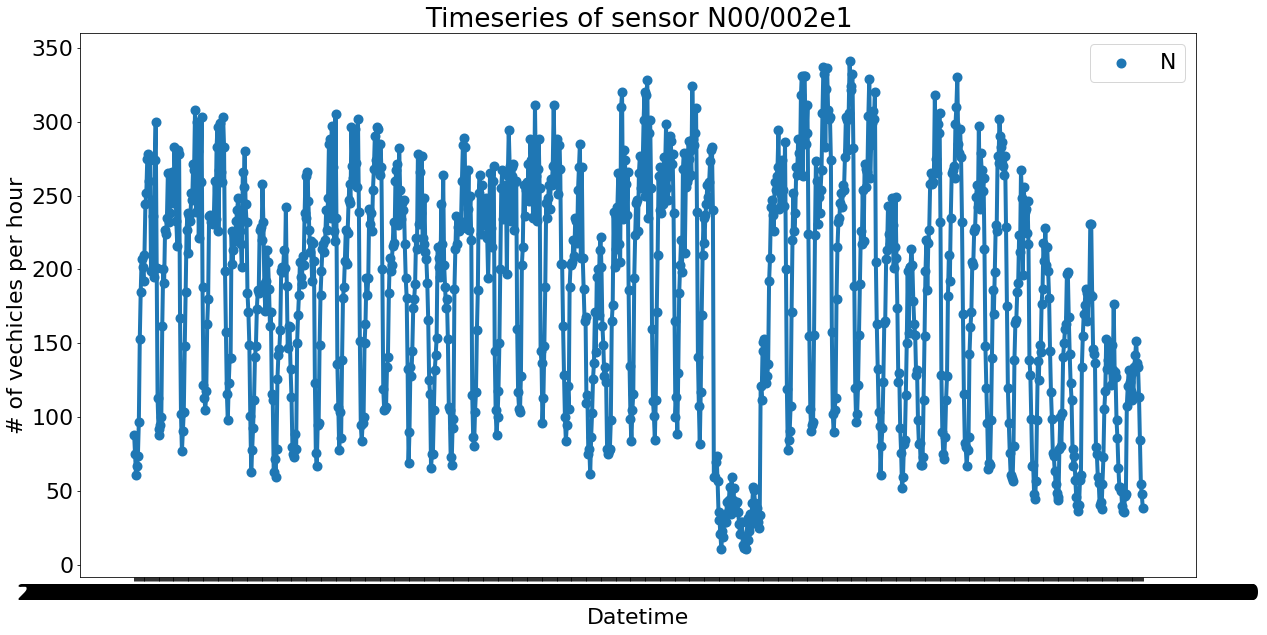

In [75]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(20, 10))
scoot_id = 0
sensor_df = scoot_individual_df_arr[scoot_id]
plt.plot(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4)
plt.scatter(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4, 
            color = color_counts, label = label_counts)
plt.title('Timeseries of sensor {scoot_id}'.format(scoot_id=scoot_ids[scoot_id]))
plt.xlabel('Datetime')
plt.ylabel('# of vechicles per hour')
plt.legend()
plt.show()

# Fit LGCP model for each sensor

In [76]:
## Set random seed
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

In [87]:
## Optimization functions - train the model for the given epochs
def optimization_step(model: gpflow.models.SVGP, X, Y):
    optimizer = tf.optimizers.Adam()
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = -model.elbo(X, Y)
        grads = tape.gradient(obj, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
def simple_training_loop(X, Y, model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10, num_batches_per_epoch: int = 10):
    tf_optimization_step = tf.function(optimization_step)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, X, Y)

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(X,Y)}")

In [88]:
## Given the data and the specific sensor this function optimise the ELBO and plot the results 
def train_sensor_model(scoot_id, X_arr, Y_arr, epochs = 100, logging_epoch_freq = 10, plot=True):
    
    ## To remove newaxis when more features
    num_features = X_arr[scoot_id][:,0][:,np.newaxis].shape[0]
    
    X = tf.convert_to_tensor(X_arr[scoot_id][:,0][:,np.newaxis])
    Y = tf.convert_to_tensor(Y_arr[scoot_id].astype(np.float64))
    
    ## To pass it as a function arg
    k = gpflow.kernels.Periodic(0.6)
    
    lik = gpflow.likelihoods.Poisson()
    
    ## Add code for inducing inputs - Needed when we run on the full data
    model = gpflow.models.SVGP(kernel = k, likelihood=lik, inducing_variable=X)
    
    ## Uncomment to see which variables are training and those that are not
    #print_summary(model)
    
    simple_training_loop(X, Y, model, epochs = epochs, 
                         logging_epoch_freq = logging_epoch_freq)
    
    if plot == True:
        plot_results(scoot_individual_df_arr, sensor_df, model, X)
    return model

In [89]:
## Given the trained model this function samples from the posterior intensity and then samples from the Poisson
## to get estimated mean and variance for the counts 
def sample_N(model, test_inputs, num_samples=10):
    samples = np.random.poisson(np.exp(model.predict_f_samples(test_inputs,num_samples)))
    samples_mean = np.mean(samplesN,axis=0)
    samples_var = np.var(samplesN,axis=0)
    
    return samples_mean, samples_var

In [90]:
## This functions plot the results together with the true counts
def plot_results(scoot_individual_df_arr, sensor_df, model, test_inputs):
    mean_N, var_N = sample_N(model, test_inputs, num_samples=10)
    
    plt.rcParams.update({'font.size': 22})
    plt.figure(figsize=(20, 10))
    scoot_id = 0
    sensor_df = scoot_individual_df_arr[scoot_id]
    plt.plot(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4)
    plt.scatter(sensor_df['measurement_start_utc'], sensor_df['n_vehicles_in_interval'], linewidth=4, 
                    color = color_counts, label = label_counts)
        
    plt.plot(sensor_df['measurement_start_utc'], averages_N,color = color_estimated_counts)
        
    plt.scatter(sensor_df['measurement_start_utc'], averages_N, color = color_estimated_counts, 
                    label = label_estimated_counts)
    plt.fill_between(sensor_df['measurement_start_utc'], 
                     mean_N[:,0] - np.sqrt(var_N)[:,0], 
                     mean_N[:,0] + np.sqrt(var_N)[:,0], 
                     facecolor= color_estimated_counts, alpha=0.4)
    plt.fill_between(sensor_df['measurement_start_utc'], 
                     mean_N[:,0] - 2*np.sqrt(var_N)[:,0], 
                     mean_N[:,0] + 2*np.sqrt(var_N)[:,0], 
                     facecolor= color_estimated_counts, alpha=0.3)
    plt.fill_between(sensor_df['measurement_start_utc'], 
                     mean_N[:,0] - 3*np.sqrt(var_N)[:,0], 
                     mean_N[:,0] + 3*np.sqrt(var_N)[:,0], 
                     facecolor= color_estimated_counts, alpha=0.2)
    plt.title('Timeseries of sensor {scoot_id}'.format(scoot_id=scoot_ids[scoot_id]))
    plt.xlabel('Datetime')
    plt.ylabel('# of vechicles per hour')
    plt.legend()
    plt.show()

In [91]:
scoot_id = 0
epochs = 2000
logging_epoch_freq = 500
new_model = train_sensor_model(scoot_id, X_arr, Y_arr, epochs, logging_epoch_freq)

ValueError: in converted code:

    <ipython-input-87-246810a2535a>:8 optimization_step  *
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:433 apply_gradients
        _ = self.iterations
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:541 __getattribute__
        return super(OptimizerV2, self).__getattribute__(name)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:655 iterations
        aggregation=tf_variables.VariableAggregation.ONLY_FIRST_REPLICA)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:805 add_weight
        aggregation=aggregation)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/training/tracking/base.py:744 _add_variable_with_custom_getter
        **kwargs_for_getter)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/base_layer_utils.py:139 make_variable
        shape=variable_shape if variable_shape else None)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:258 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:219 _variable_v1_call
        shape=shape)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/ops/variables.py:65 getter
        return captured_getter(captured_previous, **kwargs)
    /Users/Yannis/.pyenv/versions/3.7.5/envs/gla/lib/python3.7/site-packages/tensorflow_core/python/eager/def_function.py:413 invalid_creator_scope
        "tf.function-decorated function tried to create "

    ValueError: tf.function-decorated function tried to create variables on non-first call.
